# Epilepsy Detection Using EEG Data

In this example we'll use the [`cesium`](http://github.com/cesium-ml/cesium/) library to compare
various techniques for epilepsy detection using a classic EEG time series dataset from
[Andrzejak et al.](http://www.meb.uni-bonn.de/epileptologie/science/physik/eegdata.html).
The raw data are separated into five classes: Z, O, N, F, and S; we will consider a
three-class classification problem of distinguishing normal (Z, O), interictal (N, F), and
ictal (S) signals.

The overall workflow consists of three steps: first, we "featurize" the time series by
selecting some set of mathematical functions to apply to each; next, we build some
classification models which use these features to distinguish between classes;
finally, we validate our models by generating predictions for some unseen
holdout set and comparing them to the true class labels.

First, we'll load the data and inspect a representative time series from each class:

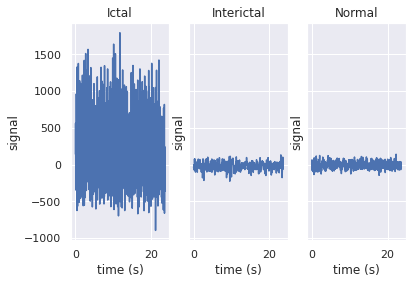

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

from cesium import datasets

eeg = datasets.fetch_andrzejak()

# Group together classes (Z, O), (N, F), (S) as normal, interictal, ictal
eeg["classes"] = eeg["classes"].astype('U16') #  allocate memory for longer class names
eeg["classes"][np.logical_or(eeg["classes"]=="Z", eeg["classes"]=="O")] = "Normal" # A: Redefine class names
eeg["classes"][np.logical_or(eeg["classes"]=="N", eeg["classes"]=="F")] = "Interictal"
eeg["classes"][eeg["classes"]=="S"] = "Ictal"

fig, ax = plt.subplots(1, len(np.unique(eeg["classes"])), sharey=True)
for label, subplot in zip(np.unique(eeg["classes"]), ax): # A: Loop thru 'Ictal', 'Interictal', 'Normal' w/ axes
    i = np.where(eeg["classes"] == label)[0][0]
    subplot.plot(eeg["times"][i], eeg["measurements"][i])
    subplot.set(xlabel="time (s)", ylabel="signal", title=label)

## Featurization
Once the data is loaded, we can generate features for each time series using the
[`cesium.featurize`](https://cesium.readthedocs.org/en/latest/api/cesium.featurize.html)
module. The `featurize` module includes many built-in choices of features which can be applied
for any type of time series data; here we've chosen a few generic features that do not have
any special biological significance.

If Celery is running, the time series will automatically be split among the available workers
and featurized in parallel; setting `use_celery=False` will cause the time series to be
featurized serially.

In [2]:
from cesium import featurize
features_to_use = ['amplitude',
                   'percent_beyond_1_std',
                   'maximum',
                   'max_slope',
                   'median',
                   'median_absolute_deviation',
                   'percent_close_to_median',
                   'minimum',
                   'skew',
                   'std',
                   'weighted_average']
fset_cesium = featurize.featurize_time_series(times=eeg["times"], values=eeg["measurements"],
                                             errors=None, features_to_use=features_to_use,
                                             targets=eeg["classes"], use_celery=True)
print(fset_cesium)

TypeError: featurize_time_series() got an unexpected keyword argument 'targets'

The output of
[`featurize_time_series`](https://cesium.readthedocs.org/en/latest/api/cesium.featurize.html#cesium.featurize.featurize_time_series)
is an `xarray.Dataset` which contains all the feature information needed to train a machine
learning model: feature values are stored as data variables, and the time series index/class
label are stored as coordinates (a `channel` coordinate will also be used later for
multi-channel data).

### Custom feature functions
Custom feature functions not built into `cesium` may be passed in using the
`custom_functions` keyword, either as a dictionary `{feature_name: function}`, or as a
[dask graph](http://dask.pydata.org/en/latest/custom-graphs.html). Functions should take
three arrays `times, measurements, errors` as inputs; details can be found in the
`cesium.featurize`
[documentation](https://cesium.readthedocs.org/en/latest/api/cesium.featurize.html).
Here we'll compute five standard features for EEG analysis provided by [Guo et al.
(2012)](http://linkinghub.elsevier.com/retrieve/pii/S0957417411003253):

In [3]:
import numpy as np
import scipy.stats

def mean_signal(t, m, e):
    return np.mean(m)

def std_signal(t, m, e):
    return np.std(m)

def mean_square_signal(t, m, e):
    return np.mean(m ** 2)

def abs_diffs_signal(t, m, e):
    return np.sum(np.abs(np.diff(m)))

def skew_signal(t, m, e):
    return scipy.stats.skew(m)

Now we'll pass the desired feature functions as a dictionary via the `custom_functions`
keyword argument.

In [4]:
guo_features = {
    'mean': mean_signal,
    'std': std_signal,
    'mean2': mean_square_signal,
    'abs_diffs': abs_diffs_signal,
    'skew': skew_signal
}

fset_guo = featurize.featurize_time_series(times=eeg["times"], values=eeg["measurements"],
                                           errors=None, targets=eeg["classes"], 
                                           features_to_use=list(guo_features.keys()),
                                           custom_functions=guo_features,
                                           use_celery=True)
print(fset_guo)

<xarray.Dataset>
Dimensions:    (channel: 1, name: 500)
Coordinates:
  * channel    (channel) int64 0
  * name       (name) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
    target     (name) object 'Normal' 'Normal' 'Normal' 'Normal' 'Normal' ...
Data variables:
    abs_diffs  (name, channel) float64 4.695e+04 6.112e+04 5.127e+04 ...
    mean       (name, channel) float64 -4.132 -52.44 12.71 -3.992 -18.0 ...
    mean2      (name, channel) float64 1.65e+03 5.133e+03 2.384e+03 ...
    skew       (name, channel) float64 0.0328 -0.09271 -0.0041 0.06368 ...
    std        (name, channel) float64 40.41 48.81 47.14 47.07 44.91 45.02 ...


### Multi-channel time series
The EEG time series considered here consist of univariate signal measurements along a
uniform time grid. But
[`featurize_time_series`](https://cesium.readthedocs.org/en/latest/api/cesium.featurize.html#cesium.featurize.featurize_time_series)
also accepts multi-channel data; to demonstrate this, we will decompose each signal into
five frequency bands using a discrete wavelet transform as suggested by [Subasi
(2005)](http://www.sciencedirect.com/science/article/pii/S0957417404001745), and then
featurize each band separately using the five functions from above.

In [5]:
import pywt

n_channels = 5
eeg["dwts"] = [pywt.wavedec(m, pywt.Wavelet('db1'), level=n_channels-1)
               for m in eeg["measurements"]]
fset_dwt = featurize.featurize_time_series(times=None, values=eeg["dwts"], errors=None,
                                           features_to_use=list(guo_features.keys()),
                                           targets=eeg["classes"],
                                           custom_functions=guo_features)
print(fset_dwt)

<xarray.Dataset>
Dimensions:    (channel: 5, name: 500)
Coordinates:
  * channel    (channel) int64 0 1 2 3 4
  * name       (name) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
    target     (name) object 'Normal' 'Normal' 'Normal' 'Normal' 'Normal' ...
Data variables:
    abs_diffs  (name, channel) float64 2.513e+04 1.806e+04 3.241e+04 ...
    skew       (name, channel) float64 -0.0433 0.06578 0.2999 0.1239 0.1179 ...
    mean2      (name, channel) float64 1.294e+04 5.362e+03 2.321e+03 664.4 ...
    mean       (name, channel) float64 -17.08 -6.067 -0.9793 0.1546 0.03555 ...
    std        (name, channel) float64 112.5 72.97 48.17 25.77 10.15 119.8 ...


The output featureset has the same form as before, except now the `channel` coordinate is
used to index the features by the corresponding frequency band. The functions in
[`cesium.build_model`](https://cesium.readthedocs.org/en/latest/api/cesium.build_model.html)
and [`cesium.predict`](https://cesium.readthedocs.org/en/latest/api/cesium.predict.html)
all accept featuresets from single- or multi-channel data, so no additional steps are
required to train models or make predictions for multichannel featuresets using the
`cesium` library.

## Model Building
Model building in `cesium` is handled by the
[`build_model_from_featureset`](https://cesium.readthedocs.org/en/latest/api/cesium.build_model.html#cesium.build_model.build_model_from_featureset)
function in the `cesium.build_model` submodule. The featureset output by
[`featurize_time_series`](https://cesium.readthedocs.org/en/latest/api/cesium.featurize.html#cesium.featurize.featurize_time_series)
contains both the feature and target information needed to train a
model; `build_model_from_featureset` is simply a wrapper that calls the `fit` method of a
given `scikit-learn` model with the appropriate inputs. In the case of multichannel
features, it also handles reshaping the featureset into a (rectangular) form that is
compatible with `scikit-learn`.

For this example, we'll test a random forest classifier for the built-in `cesium` features,
and a 3-nearest neighbors classifier for the others, as suggested by [Guo et al.
(2012)](http://linkinghub.elsevier.com/retrieve/pii/S0957417411003253).

In [6]:
from cesium.build_model import build_model_from_featureset
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split

train, test = train_test_split(np.arange(len(eeg["classes"])), random_state=0)

rfc_param_grid = {'n_estimators': [8, 16, 32, 64, 128, 256, 512, 1024]}
model_cesium = build_model_from_featureset(fset_cesium.isel(name=train),
                                          RandomForestClassifier(max_features='auto',
                                                                 random_state=0),
                                          params_to_optimize=rfc_param_grid)
knn_param_grid = {'n_neighbors': [1, 2, 3, 4]}
model_guo = build_model_from_featureset(fset_guo.isel(name=train),
                                        KNeighborsClassifier(),
                                        params_to_optimize=knn_param_grid)
model_dwt = build_model_from_featureset(fset_dwt.isel(name=train),
                                        KNeighborsClassifier(),
                                        params_to_optimize=knn_param_grid)

## Prediction
Making predictions for new time series based on these models follows the same pattern:
first the time series are featurized using
[`featurize_timeseries`](https://cesium.readthedocs.org/en/latest/api/cesium.featurize.html#cesium.featurize.featurize_time_series),
and then predictions are made based on these features using
[`predict.model_predictions`](https://cesium.readthedocs.org/en/latest/api/cesium.predict.html#cesium.predict.model_predictions),

In [7]:
from sklearn.metrics import accuracy_score
from cesium.predict import model_predictions

preds_cesium = model_predictions(fset_cesium, model_cesium, return_probs=False)
preds_guo = model_predictions(fset_guo, model_guo, return_probs=False)
preds_dwt = model_predictions(fset_dwt, model_dwt, return_probs=False)

print("Built-in cesium features: training accuracy={:.2%}, test accuracy={:.2%}".format(
          accuracy_score(preds_cesium[train], eeg["classes"][train]),
          accuracy_score(preds_cesium[test], eeg["classes"][test])))
print("Guo et al. features: training accuracy={:.2%}, test accuracy={:.2%}".format(
          accuracy_score(preds_guo[train], eeg["classes"][train]),
          accuracy_score(preds_guo[test], eeg["classes"][test])))
print("Wavelet transform features: training accuracy={:.2%}, test accuracy={:.2%}".format(
          accuracy_score(preds_dwt[train], eeg["classes"][train]),
          accuracy_score(preds_dwt[test], eeg["classes"][test])))

Built-in cesium features: training accuracy=100.00%, test accuracy=83.20%
Guo et al. features: training accuracy=90.93%, test accuracy=84.80%
Wavelet transform features: training accuracy=100.00%, test accuracy=95.20%


The workflow presented here is intentionally simplistic and omits many important steps
such as feature selection, model parameter selection, etc. Since we make use of standard
`scikit-learn` models, additional steps can be incorporated in the same way they would be
for any other (non-time domain) machine learning problem.


IPython notebook: <a href="EEG_Example.ipynb" download="EEG_Example.ipynb">download</a>